In [3]:
#import statements
import datetime
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.animation as manimation
from matplotlib.animation import FFMpegWriter
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import ipywidgets as widgets
from ipywidgets import interactive
#from keypass import NOAA_api
import time
import pylab as pl
from IPython import display

import geopandas as gpd
from functools import partial
import fiona
import pyproj

## Read in data - ocean region and bin depth have been added as columns from Phase I notebook. 

This notebook:
1. Explores the cruise ID as a category ML model input
2. Makes a datetime column in the dataset 
3. Finds empty columns 
4. Splits the dataset to smaller CSVs for Github repo upload 

Variable definitions from the dataset documentation can be found at: <br>


https://essd.copernicus.org/preprints/essd-2020-165/essd-2020-165.pdf

In [4]:
df= pd.read_csv('C:\\Users\\ossan\\DATA606\\DATA\\mergedOceans_CLEANED.csv')
df

,cruise,station,cast,year,month,day,hour,minute,latitude,longitude,...,he,neon,o18,toc,doc,don,tdn,chla,Ocean Region,depthBinned
0,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.5670,7.2267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arctic,< 200
1,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.5670,7.2267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arctic,< 200
2,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.5670,7.2267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arctic,< 200
3,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.5670,7.2267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arctic,< 200
4,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.5670,7.2267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arctic,< 200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253234,2103.0,6348.0,1.0,2018.0,9.0,14.0,10.0,8.0,-7.2578,162.0022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pacific,< 4000
1253235,2103.0,6348.0,1.0,2018.0,9.0,14.0,10.0,8.0,-7.2578,162.0022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pacific,< 4000
1253236,2103.0,6348.0,1.0,2018.0,9.0,14.0,10.0,8.0,-7.2578,162.0022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pacific,< 4000
1253237,2103.0,6348.0,1.0,2018.0,9.0,14.0,10.0,8.0,-7.2578,162.0022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pacific,< 4000


In [5]:
df.columns

Index(['cruise', 'station', 'cast', 'year', 'month', 'day', 'hour', 'minute',
       'latitude', 'longitude', 'bottomdepth', 'maxsampdepth', 'bottle',
       'pressure', 'depth', 'temperature', 'theta', 'salinity', 'sigma0',
       'sigma1', 'sigma2', 'sigma3', 'sigma4', 'gamma', 'oxygen', 'aou',
       'nitrate', 'nitrite', 'silicate', 'phosphate', 'tco2', 'talk', 'fco2',
       'fco2temp', 'phts25p0', 'phtsinsitutp', 'cfc11', 'pcfc11', 'cfc12',
       'pcfc12', 'cfc113', 'pcfc113', 'ccl4', 'pccl4', 'sf6', 'psf6', 'c13',
       'c14', 'h3', 'he3', 'he', 'neon', 'o18', 'toc', 'doc', 'don', 'tdn',
       'chla', 'Ocean Region', 'depthBinned'],
      dtype='object')

### Making a date column from year, month, day 

In [6]:
#make a date column
from datetime import datetime

df['Date'] = (df['year'].astype(int).astype(str)+'/'+df['month'].astype(int).astype(str)+'/'+df['day'].astype(int).astype(str))
df['Date']= pd.to_datetime(df['Date']) 

### Cruise id check 
The data for the 106 new cruises were retrieved from data centers (typically CCHDO, NCEI, PANGAEA) or submitted
directly to us. Each cruise is identified by an EXPOCODE. The EXPOCODE is guaranteed to be unique and constructed
by combining the country code and platform code with the date of departure in the format YYYYMMDD. The country
and platform codes were taken from the ICES (International Council for the Exploration of the Sea) library
(https://vocab.ices.dk/, last access: 20 June 2020).

Data from the 106 new cruises were merged and sorted according to EXPOCODE, station, and pressure.
GLODAP cruise numbers were assigned consecutively, starting from 2001, so they can be distinguished from the
GLODAPv2.2019 cruises that ended at 1116.

### Determining if the cruises repeat over the same areas (visually and with counting cruise IDs over the years). 

In [84]:
#get the elapsed time between rows 
by_group = df.groupby(df.cruise)
#find the difference after grouping by cruise 
df['elapsed'] = list(by_group.apply(lambda x: x['Date']-x['Date'].shift()))
df['elapsed']=df['elapsed'].dt.days
df['elapsed'].value_counts()

 0.0      1233637
 1.0        15033
 2.0         1304
-1.0          520
 3.0          469
           ...   
-20.0           1
 267.0          1
 108.0          1
 260.0          1
 360.0          1
Name: elapsed, Length: 191, dtype: int64

In [85]:
#get an idea of which cruise IDs are reeating by seeing only rows with >300 days between entries 
cruises = df[df['elapsed']>300]
a=cruises.groupby(['cruise'])
for i,ii in a: 
    print(i,ii)

353.0         cruise  station  cast    year  month   day  hour  minute  latitude  \
222448   353.0     91.0   1.0  2007.0    3.0  27.0   0.0    38.0   -27.108   

        longitude  ...  o18  toc   doc  don  tdn  chla  Ocean Region  \
222448     95.002  ...  NaN  NaN  41.6  NaN  NaN   NaN        Indian   

        depthBinned       Date  elapsed  
222448       < 1000 2007-03-27   1282.0  

[1 rows x 62 columns]
370.0         cruise  station  cast    year  month   day  hour  minute  latitude  \
236533   370.0      3.0   3.0  1985.0    2.0  27.0   0.0     0.0    -27.05   

        longitude  ...  o18  toc  doc  don  tdn  chla  Ocean Region  \
236533       56.9  ...  NaN  NaN  NaN  NaN  NaN   NaN        Indian   

        depthBinned       Date  elapsed  
236533       < 4000 1985-02-27    730.0  

[1 rows x 62 columns]
477.0         cruise  station  cast    year  month   day  hour  minute  latitude  \
974007   477.0     79.0   1.0  2001.0    8.0  22.0  23.0    51.0    51.808   
974139   4

In [86]:
#do the station IDs offer any clarity? not really 
df.station.value_counts()

4.0        9725
9.0        9497
6.0        9411
12.0       9327
7.0        9231
           ... 
32026.0       1
32027.0       1
32028.0       1
32029.0       1
2026.0        1
Name: station, Length: 7185, dtype: int64

## make video of the cruises over the years grouped by cruise (see link)

https://www.youtube.com/watch?v=BjkgtC0cTQ0&ab_channel=AngelaOssana

In [ ]:
aa=df.groupby(['cruise'])


for d, frame in aa:
    fig, axe = plt.subplots(1, 1,figsize=(20,15))
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.plot(color='white', ax=axe,edgecolor='black', )
    sns.scatterplot(frame.longitude,frame.latitude, hue=(frame.year).astype('category'));
    plt.ylim((-90,90));plt.xlim((-185,200))   
    plt.xlabel('Longitude',fontsize=16,fontweight='bold'); plt.ylabel('Latitude',fontsize=16,fontweight='bold')
    axe.legend(loc='upper right')
    display.clear_output(wait=True)
    time.sleep(.3)
    plt.title(('CRUISE LABEL: ' +str(d)),fontsize=20,fontweight='bold')
    plt.tight_layout()
    fig.savefig('C:\\Users\\ossan\\DATA606\\CRUISES_YEAR\\' + str(d) + '.png')
    plt.show()


### Make a gif 

In [73]:
import os
i=os.listdir('C:\\Users\\ossan\\DATA606\\CRUISES_YEAR\\' )
jpg=[]
for x in i: 
    jpg.append('C:\\Users\\ossan\\DATA606\\CRUISES_YEAR\\'+x)

import imageio
images = []
for filename in jpg:
    images.append(imageio.imread(filename))
imageio.mimsave('C:\\Users\\ossan\\DATA606\\cruises.gif', images,format='GIF',duration=.5)

### Make a movie

Source code: https://www.geeksforgeeks.org/python-create-video-using-multiple-images-using-opencv/

In [ ]:
# Video Generating function https://www.geeksforgeeks.org/python-create-video-using-multiple-images-using-opencv/
import cv2 
def generate_video(): 
    image_folder = 'C:\\Users\\ossan\\DATA606\\CRUISES_YEAR\\'# make sure to use your folder 
    video_name = 'Cruises.avi'
    os.chdir("C:\\Users\\ossan\\DATA606\\") 
      
    images = [img for img in os.listdir(image_folder) 
              if img.endswith(".jpg") or img.endswith(".jpeg") or img.endswith("png")]   
  
    frame = cv2.imread(os.path.join(image_folder, images[0])) 
    height, width, layers = frame.shape;    video = cv2.VideoWriter(video_name, 0, 1, (width, height))  
  
    # Appending the images to the video one by one 
    for image in images:  
        video.write(cv2.imread(os.path.join(image_folder, image)))  
      
    # Deallocating memories taken for window creation 
    cv2.destroyAllWindows()  
    video.release()  # releasing the video generated 
  
  
# Calling the generate_video function 
generate_video() 

In [4]:
a = []
b=[]
for i in df.columns:
    #make list of null % of each column 
    #print("{:0.2f}".format(100*(df[i].isnull().sum()/len(df))) +'% Null rows for ' + str(i) +' '  )
    b.append(i)
    a.append("{:0.2f}".format(100*(df[i].isnull().sum()/len(df))))

#zip lists 
null=pd.DataFrame(list(zip(a,b)),columns=['%Null','Col'])

#show the null low to high 
null['%Null']=null['%Null'].astype('float') #convert obj to float 
null.sort_values(by=['%Null'])

,%Null,Col
0,0.00,cruise
45,0.00,psf6
43,0.00,pccl4
41,0.00,pcfc113
39,0.00,pcfc12
37,0.00,pcfc11
33,0.00,fco2temp
58,0.00,Ocean Region
23,0.00,gamma
22,0.00,sigma4


### There are a lot of data columns with mostly null data. 

Dissolved organic nitrogen, total organic carbon, $\delta^{18}O$, neon, total dissolved nitrogen, $^{3}H$, $fCO_{2}$,  $\Delta^{14}C$,$\delta^{13}C$, helium, $\delta^3He$, $CCl_4$, chlorophyll *a*, dissolved organic carbon, $SF_6$, CFC-113, CFC-11, CFC-12

The total alkalinity is similar to salinity measurements, reflecting the buffering capacity of the ocean water, or the resistance to pH changes. 

### Dropped Columns

The columns cruise, cast, and timestamps will likely not be relevant features for the ML model. The day, hour and minute are too granular of a representation of time in the span of the dataset (50 years) $^{[1]}$. The cruise ID is not able to be used as a categorical variable, since cruises do not repeat from year to year. Those cruise IDs with multiple cruises did not repeat the same locations from year to year. The cast and bottle is made irrelevant by the quality control checks of the data by the dataset owners'. 

Stations may prove to be a useful categorical feature as they are representative of a geolocation. 
<br>


<table>
  
  <tbody>
    <tr>
      <td>sf6</td>
      <td>doc</td>
        <td>chla</td>
    </tr>
    <tr>
      <td>ccl4</td>
      <td>he3</td>
         <td>c14</td>
    </tr>
        <tr>
      <td>he</td>
      <td>c13</td>
         <td>fco2</td>
    </tr>
       <tr>
      <td>h3</td>
      <td>tdn</td>
         <td>neon</td>
    </tr>
       <tr>
      <td>o18</td>
      <td>toc</td>
         <td>don</td>
    </tr>
       <tr>
      <td>cfc113</td>
      <td>sigma4</td>
         <td></td>
    </tr>
    </table>
[1] H. C. Bittig et al., “An Alternative to Static Climatologies: Robust Estimation of Open Ocean CO2 Variables and Nutrient Concentrations From T, S, and O2 Data Using Bayesian Neural Networks,” Front. Mar. Sci., vol. 5, 2018.


#### View the percent of null rows for columns will many missing values. 

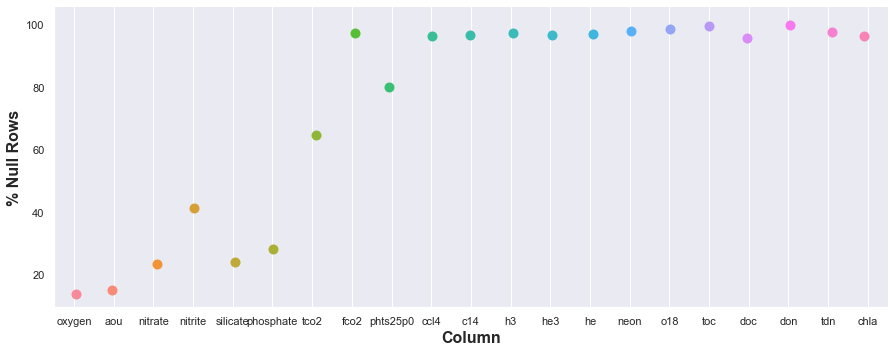

In [95]:

ax=sns.catplot(x="Col", y="%Null", 
               data=null.drop([0,1,2,3,4,8,9,10,11,12,13,14,15,16,17,18,19,58,20,21,22,23,59,
     6,7,5,38,31,33,44,36,35,37,39,40,41,45,46,43]),height=5, aspect=15.7/6.27,  s = 10)
plt.xlabel('Column',fontsize=16,fontweight='bold')
plt.ylabel('% Null Rows',fontsize=16,fontweight='bold')
sns.set()
plt.grid()
plt.show()


#### Group by the ocean region and year to see when TCO2 values are missing the most. 

In [10]:
i=test.groupby(['Ocean Region','year']).size().reset_index(name='counts')

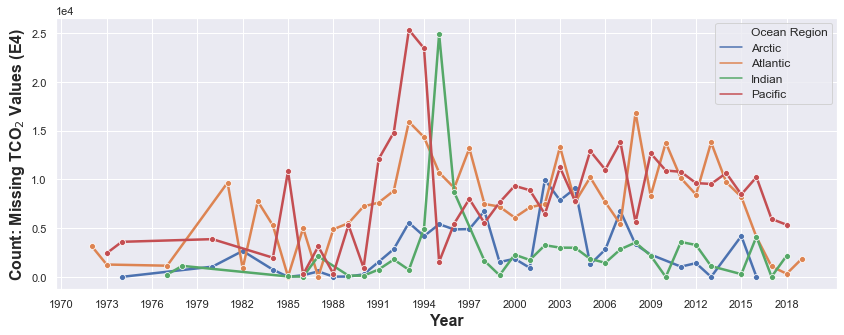

In [40]:
#fig size 
plt.figure(figsize=(14, 5))
ax=sns.lineplot(i['year'],i['counts'],hue="Ocean Region", data = i, marker="o", linewidth=2.5);
sns.set(style='darkgrid',)
plt.xlabel('Year',fontsize=16,fontweight='bold')
plt.ylabel('Count: Missing TCO$_2$ Values (E4)',fontsize=16,fontweight='bold')
plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title

#bar annotations 
#for p in ax.patches:
#    ax.annotate(format(p.get_height(), '.0f'),(p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xticks(np.arange(1970,2020, 3))


plt.show()  

## Final cleanup of columns for github repo 

<br>


<table>
  
  <tbody>
    <tr>
      <td>sf6</td>
      <td>doc</td>
        <td>chla</td>
    </tr>
    <tr>
      <td>ccl4</td>
      <td>he3</td>
         <td>c14</td>
    </tr>
        <tr>
      <td>he</td>
      <td>c13</td>
         <td>fco2</td>
    </tr>
       <tr>
      <td>h3</td>
      <td>tdn</td>
         <td>neon</td>
    </tr>
       <tr>
      <td>o18</td>
      <td>toc</td>
         <td>don</td>
    </tr>
       <tr>
      <td>cfc113</td>
      <td>sigma4</td>
         <td></td>
    </tr>
    </table>

In [87]:
df1=df
outputCSV=df1.drop(columns=['sf6','doc','chla','ccl4','he3','c14','he','c13','fco2','h3','tdn',
                          'neon','o18','toc','don','cfc113','sigma4','elapsed'])

In [ ]:
####check before output to csv 
a = []
b=[]
for i in outputCSV.columns:
    b.append(i);    a.append("{:0.2f}".format(100*(df[i].isnull().sum()/len(df))))

#zip lists 
null=pd.DataFrame(list(zip(a,b)),columns=['%Null','Col'])

#show the null low to high 
null['%Null']=null['%Null'].astype('float') #convert obj to float 
null.sort_values(by=['%Null'])

### final csv for local use

In [89]:
outputCSV.to_csv('C:\\Users\\ossan\\DATA606\\DATA\\cleanedFINAL.csv',index=False)

## Split the data csvs for github repo

In [108]:
d= 0 
last = 0 
for i in range(0,(len(outputCSV)-1),75000):
    if i != 0: #if not first iteration do this 
        print(last,i)
        outputCSV[last:i].to_csv('C:\\Users\\ossan\\DATA606\\DATA\\SPLIT\\GLODAP_split' + str(d)+ '.csv',index=False)
        last = i 
        print(d)
        d =d+1 


0 75000
0
75000 150000
1
150000 225000
2
225000 300000
3
300000 375000
4
375000 450000
5
450000 525000
6
525000 600000
7
600000 675000
8
675000 750000
9
750000 825000
10
825000 900000
11
900000 975000
12
975000 1050000
13
1050000 1125000
14
1125000 1200000
15


In [111]:
print(i,d)

1200000 16


In [112]:
#last one
outputCSV[i:(len(outputCSV)-1)].to_csv('C:\\Users\\ossan\\DATA606\\DATA\\SPLIT\\GLODAP_split' + str(d)+ '.csv',index=False)